In [1]:
import pandas as pd
import numpy as np
import torch
import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as layers
from alive_progress import alive_bar
import matplotlib.pyplot as plt
import os
import shutil

In [2]:
# RUN ONCE

if (os.exists("Fall")):
    os.rmdir("Fall")
    os.mkdir("Fall")
if (os.exists("Not Fall")):
    os.rmdir("Not Fall")
    os.mkdir("Not Fall")
with alive_bar(force_tty=True) as bar:
    for folder in os.listdir('sensor_data'):
        folder_path  = f'sensor_data/{folder}'
        for file in os.listdir(folder_path):
            file_path   = f'{folder_path}/{file}'
            with open(file_path, "rbU") as f:
                num_lines = sum(1 for _ in f)
            if(19<int(file[4:6])<35):
                if(num_lines<=1000):
                    shutil.copy(file_path,'Fall')
            else:
                if(num_lines<=1000):
                    shutil.copy(file_path,'Not Fall')
            bar()

            

AttributeError: module 'os' has no attribute 'exists'

In [2]:
features = ['AccX','AccY','AccZ','GyrX','GyrY','GyrZ','EulerX','EulerY','EulerZ']

In [3]:
X,Y = [],[]

In [4]:
df = None
X,Y = [],[]
with alive_bar(force_tty=True) as bar: 
    for file in (os.listdir('Fall')):
        file_path = f'Fall/{file}'
        df = pd.read_csv(file_path,usecols=features)
        df = df.reindex(range(1000), fill_value=0)
        X.append(tf.convert_to_tensor(df))
        Y.append(1)
        bar()

# print(df.head())
# print(df.tail())

|▶▶▶▶▶▶▶▶▶▶▶▶▶▶                          | ▁▃▅ 0 in 0s (0.0/s) 

|████████████████████████████████████████| 2306 in 15.8s (145.50/s)             


In [5]:
df = None
with alive_bar(force_tty=True) as bar:
    for file in os.listdir('Not Fall'):
        file_path = f'Not Fall/{file}'
        df = pd.read_csv(file_path,usecols=features)
        df = df.reindex(range(1000), fill_value=0)
        X.append(tf.convert_to_tensor(df))
        Y.append(0)
        bar()

# print(df.head())
# print(df.tail())

|████████████████████████████████████████| 2253 in 9.8s (229.24/s)              


In [6]:
X_tensor = np.asarray(X)

In [7]:
Y_tensor = np.asarray(Y)


In [8]:
INPUT_DIM = 9
OUTPUT_DIM = 1
SEQUENCE_LEN = 1000
loss="binary_crossentropy"
optimizer="adam"
metrics=['accuracy']

In [9]:
y_tensor=Y_tensor
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.20, random_state=42)
X_val,X_test,y_val,y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=42)


In [20]:
model3 = keras.Sequential()
model3.add(layers.SimpleRNN(64,input_dim=INPUT_DIM,input_length=SEQUENCE_LEN))
model3.add(layers.Dense(16,activation="relu"))
model3.add(layers.Dense(OUTPUT_DIM,activation="sigmoid"))
model3.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [21]:
history3 = model3.fit(X_train,y_train,batch_size=16,epochs=10,validation_data=(X_val,y_val),verbose=True)

Epoch 1/10
228/228 [==============================] - 223s 977ms/step - loss: 0.6981 - accuracy: 0.5051 - val_loss: 0.6935 - val_accuracy: 0.5044
Epoch 2/10
228/228 [==============================] - 234s 1s/step - loss: 0.6980 - accuracy: 0.4927 - val_loss: 0.6952 - val_accuracy: 0.4583
Epoch 3/10
228/228 [==============================] - 232s 1s/step - loss: 0.6967 - accuracy: 0.5007 - val_loss: 0.6971 - val_accuracy: 0.4934
Epoch 4/10
228/228 [==============================] - 187s 821ms/step - loss: 0.6934 - accuracy: 0.5144 - val_loss: 0.6973 - val_accuracy: 0.5482
Epoch 5/10
228/228 [==============================] - 215s 945ms/step - loss: 0.6846 - accuracy: 0.5522 - val_loss: 0.6765 - val_accuracy: 0.5746
Epoch 6/10
228/228 [==============================] - 165s 723ms/step - loss: 0.6382 - accuracy: 0.6638 - val_loss: 0.6336 - val_accuracy: 0.6404
Epoch 7/10
228/228 [==============================] - 162s 708ms/step - loss: 0.6838 - accuracy: 0.5665 - val_loss: 0.6938 - val_a

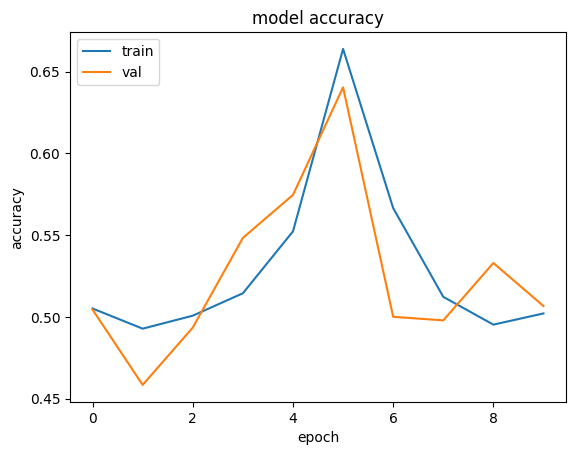

In [22]:
np.save("model3.npy",history3.history)
history3.history
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [23]:
evaluation = model3.evaluate(X_test,y_test,verbose=True,return_dict=True)
evaluation

15/15 [==============================] - 2s 141ms/step - loss: 0.6952 - accuracy: 0.4781


{'loss': 0.6952056288719177, 'accuracy': 0.4780701696872711}

In [24]:
from sklearn.metrics import classification_report

y_pred = model3.predict(X_test, batch_size=16, verbose=1)
y_pred = y_pred>0.5
# print(y_pred)
print(classification_report(y_test, y_pred))

29/29 [==============================] - 4s 128ms/step
              precision    recall  f1-score   support

           0       0.46      0.48      0.47       218
           1       0.50      0.47      0.49       238

    accuracy                           0.48       456
   macro avg       0.48      0.48      0.48       456
weighted avg       0.48      0.48      0.48       456



In [25]:
model3.save("model3_1.h5",save_format="h5")

In [42]:
converter = tf.lite.TFLiteConverter.from_keras_model(model3)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert() 
# Save the model.
with open('model3_1.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\prach\AppData\Local\Temp\tmpy01bdfox\assets


INFO:tensorflow:Assets written to: C:\Users\prach\AppData\Local\Temp\tmpy01bdfox\assets


In [12]:
model4 = keras.Sequential()
model4.add(layers.SimpleRNN(128,input_dim=INPUT_DIM,input_length=SEQUENCE_LEN))
model4.add(layers.Dense(64
                        ,activation="relu"))
model4.add(layers.Dense(32,activation="relu"))
model4.add(layers.Dense(16,activation="relu"))
model4.add(layers.Dense(OUTPUT_DIM,activation="sigmoid"))
model4.compile(loss=loss,optimizer=optimizer,metrics=metrics)

In [13]:
history = model4.fit(X_train,y_train,batch_size=16,epochs=20,validation_data=(X_val,y_val),verbose=True)


Epoch 1/10
228/228 [==============================] - 206s 896ms/step - loss: 0.6979 - accuracy: 0.4936 - val_loss: 0.6989 - val_accuracy: 0.4912
Epoch 2/10
228/228 [==============================] - 193s 846ms/step - loss: 0.6978 - accuracy: 0.5155 - val_loss: 0.6951 - val_accuracy: 0.5154
Epoch 3/10
228/228 [==============================] - 165s 724ms/step - loss: 0.6968 - accuracy: 0.4897 - val_loss: 0.6869 - val_accuracy: 0.5329
Epoch 4/10
228/228 [==============================] - 164s 718ms/step - loss: 0.6959 - accuracy: 0.4957 - val_loss: 0.6981 - val_accuracy: 0.4583
Epoch 5/10
228/228 [==============================] - 209s 916ms/step - loss: 0.6963 - accuracy: 0.4867 - val_loss: 0.6968 - val_accuracy: 0.4868
Epoch 6/10
228/228 [==============================] - 153s 670ms/step - loss: 0.6944 - accuracy: 0.4936 - val_loss: 0.6928 - val_accuracy: 0.4912
Epoch 7/10
228/228 [==============================] - 154s 674ms/step - loss: 0.6930 - accuracy: 0.4985 - val_loss: 0.6930 -

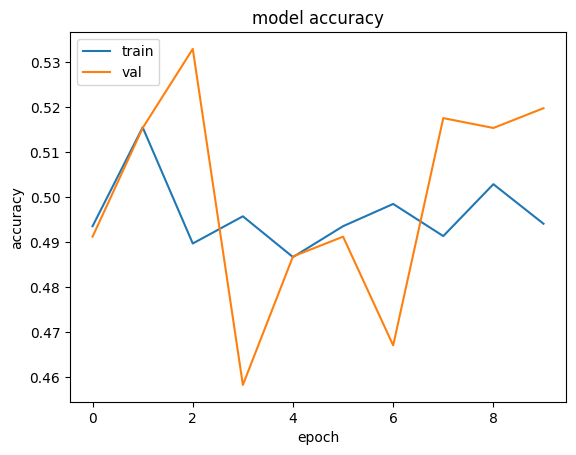

In [14]:
np.save("model4.npy",history.history)
history.history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [15]:
evaluation4 = model4.evaluate(X_test,y_test,verbose=True,return_dict=True)
evaluation4



15/15 [==============================] - 2s 138ms/step - loss: 0.6921 - accuracy: 0.4912


{'loss': 0.6920875906944275, 'accuracy': 0.4912280738353729}

In [16]:
from sklearn.metrics import classification_report

y_pred = model4.predict(X_test, batch_size=16, verbose=1)
y_pred = y_pred>0.5
# print(y_pred)
print(classification_report(y_test, y_pred))

29/29 [==============================] - 4s 132ms/step
              precision    recall  f1-score   support

           0       0.47      0.54      0.50       218
           1       0.51      0.45      0.48       238

    accuracy                           0.49       456
   macro avg       0.49      0.49      0.49       456
weighted avg       0.49      0.49      0.49       456



In [17]:
converter = tf.lite.TFLiteConverter.from_keras_model(model4)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert() 
# Save the model.
with open('model4_1.tflite', 'wb') as f:
  f.write(tflite_model)


INFO:tensorflow:Assets written to: C:\Users\prach\AppData\Local\Temp\tmp7vsbak38\assets


In [18]:
model4.save("model4_1.h5",save_format="h5")

In [44]:
model4 = tf.keras.models.load_model("model4_1.h5")

In [27]:
import math
import numpy as np

def Euler(roll,pitch,yaw):
    return pitch,roll,yaw
    return pitch*100,roll*100,yaw*100
    # ry = roll
    # rx = pitch
    # rz = yaw
    # yawMatrix = np.matrix([
    # [math.cos(yaw), -math.sin(yaw), 0],
    # [math.sin(yaw), math.cos(yaw), 0],
    # [0, 0, 1]
    # ])

    # pitchMatrix = np.matrix([
    # [math.cos(pitch), 0, math.sin(pitch)],
    # [0, 1, 0],
    # [-math.sin(pitch), 0, math.cos(pitch)]
    # ])

    # rollMatrix = np.matrix([
    # [1, 0, 0],
    # [0, math.cos(roll), -math.sin(roll)],
    # [0, math.sin(roll), math.cos(roll)]
    # ])

    # R = yawMatrix * pitchMatrix * rollMatrix

    # theta = math.acos(((R[0, 0] + R[1, 1] + R[2, 2]) - 1) / 2)
    # multi = 1 / (2 * math.sin(theta))

    # rx = multi * (R[2, 1] - R[1, 2]) * theta
    # ry = multi * (R[0, 2] - R[2, 0]) * theta
    # rz = multi * (R[1, 0] - R[0, 1]) * theta

    return rx*57.2958*10, ry*57.2958*10, rz*57.2958*10
# 


In [28]:
from scipy.ndimage.filters import uniform_filter1d
from scipy import stats

C:\Users\prach\AppData\Local\Temp\ipykernel_13248\3541330012.py:1: DeprecationWarning: Please use `uniform_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter1d


In [30]:
result = pd.read_csv('result.csv')
result = result[:5000]
result['EulerX'] = 0
result['EulerY'] = 0
result['EulerZ'] = 0
print(len(result))

for i in range(len(result)):
    result.loc[i,['EulerX','EulerY','EulerZ']] = (Euler(*result.loc[i,['Roll','Pitch','Yaw']]))
result = result.drop(columns=['Timestamp','Roll','Yaw','Pitch'])
for col in range(9):
    result.iloc[:,col] = uniform_filter1d(result.iloc[:,col],size=10)

result['Acc_X'],result['Acc_Z'] = result['Acc_Z'],result['Acc_X']
result['Gyro_X'],result['Gyro_Z'] = result['Gyro_Z'],result['Gyro_X'] 
result['EulerX'],result['EulerZ'] = result['EulerZ'],result['EulerX'] 
result['Acc_X'] = result['Acc_X']/-9.8
result['Acc_Y'] = result['Acc_Y']/-9.8
result['Acc_Z'] = result['Acc_Z']/-9.8


# result['Acc_X']= result['Acc_X']*0.5 + 0.25
# result['Acc_Y']= result['Acc_Y'] * 0.4 - 0.7
# result['Acc_Z']= result['Acc_Z'] - 0.5

# result['Gyro_X']= result['Gyro_X']*10
# result['Gyro_Y']= result['Gyro_Y']*10
# result['Gyro_Z']= result['Gyro_Z']*10


# result['EulerX']= result['EulerX']*0.1+20 
# result['EulerY']= result['EulerY']
# result['EulerZ']= result['EulerZ']


test = result
# for col in range(9):
#     test.iloc[:,col] = uniform_filter1d(test.iloc[:,col],size=10)

test.head()



5000


,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,EulerX,EulerY,EulerZ
0,-0.855361,-0.495021,-0.081222,-0.043767,-0.016676,-0.020127,30.209808,-5.424178,-29.947860
1,-0.855922,-0.494924,-0.081209,-0.043706,-0.016004,-0.020250,30.241039,-5.419857,-29.927132
2,-0.857436,-0.494570,-0.081234,-0.043233,-0.014889,-0.020815,30.312507,-5.412054,-29.866531
3,-0.859469,-0.493996,-0.081472,-0.042332,-0.013637,-0.021807,30.340019,-5.415223,-29.779811
4,-0.861966,-0.493330,-0.081564,-0.041186,-0.013118,-0.023121,30.297469,-5.405972,-29.676145


In [26]:
truth = pd.read_csv('Not Fall/S06T02R01.csv')
truth.drop(columns=['TimeStamp(s)','FrameCounter'],inplace=True)
truth.reindex(range(1000), fill_value=0)

,AccX,AccY,AccZ,GyrX,GyrY,GyrZ,EulerX,EulerY,EulerZ
0,-0.059,-1.007,-0.050,-3.609635,-7.161975,0.859437,87.926135,-3.093973,-53.124666
1,-0.051,-1.002,-0.060,-5.385805,-4.640960,0.859437,87.874568,-3.099703,-53.170502
2,-0.058,-0.999,-0.066,-5.500397,-4.812847,0.916733,87.823002,-3.111162,-53.222069
3,-0.062,-0.999,-0.070,-5.500397,-4.354481,0.974029,87.771436,-3.122621,-53.262176
4,-0.061,-0.999,-0.076,-5.443101,-3.838819,1.145916,87.685492,-3.139810,-53.290824
...,...,...,...,...,...,...,...,...,...
995,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
996,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
997,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
998,0.000,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
predictions = []
for i in range(250,len(test)-500):
    x = test[i:i+500].reset_index(drop=True)
    x = x.reindex(range(1000))
    test_tensor = tf.convert_to_tensor(x)
    print(x.shape)
    predictions.append(model2.predict(np.asarray([test_tensor])))
    temp = truth[i:i+500].reset_index(drop=True)
    temp = temp.reset_index()
    for col in range(9):
        print(x.columns[col])
        plt.figure()
        plt.plot(x.iloc[:,col],color='orange')
        plt.plot(temp.iloc[:,col],color='green')
    break
    

(1000, 9)
1/1 [==============================] - 0s 101ms/step


IndexError: Too many levels: Index has only 1 level, not 1001

In [24]:
import time

In [31]:
predictions = []
print(test.head())
prediction_time = []
for i in range(250,len(test)-500):
    x = test[i:i+500].reset_index(drop=True)
    test_tensor = tf.convert_to_tensor(x)
    predictions.append(model2.predict(np.asarray([test_tensor])).item())

      Acc_X     Acc_Y     Acc_Z    Gyro_X    Gyro_Y    Gyro_Z     EulerX  \
0 -0.855361 -0.495021 -0.081222 -0.043767 -0.016676 -0.020127  30.209808   
1 -0.855922 -0.494924 -0.081209 -0.043706 -0.016004 -0.020250  30.241039   
2 -0.857436 -0.494570 -0.081234 -0.043233 -0.014889 -0.020815  30.312507   
3 -0.859469 -0.493996 -0.081472 -0.042332 -0.013637 -0.021807  30.340019   
4 -0.861966 -0.493330 -0.081564 -0.041186 -0.013118 -0.023121  30.297469   

     EulerY     EulerZ  
0 -5.424178 -29.947860  
1 -5.419857 -29.927132  
2 -5.412054 -29.866531  
3 -5.415223 -29.779811  
4 -5.405972 -29.676145  
1/1 [==============================] - 0s 36ms/step


KeyboardInterrupt: 

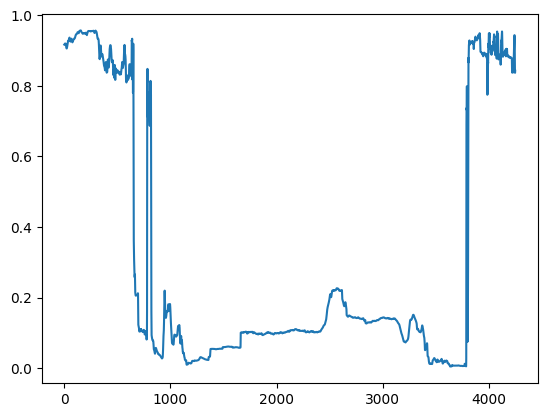

In [40]:
plt.plot(predictions)
# pd.Series({'time':prediction_time}).head()


In [30]:
result2 = pd.read_csv('phoneThrow.csv')
result2 = result2[:5000]
result2['EulerX'] = 0
result2['EulerY'] = 0
result2['EulerZ'] = 0
print(len(result2))

for i in range(len(result2)):
    result2.loc[i,['EulerX','EulerY','EulerZ']] = (Euler(*result2.loc[i,['Roll','Pitch','Yaw']]))
result2 = result2.drop(columns=['Timestamp','Roll','Yaw','Pitch'])
for col in range(9):
    result2.iloc[:,col] = uniform_filter1d(result2.iloc[:,col],size=10)

result2['Acc_X'],result2['Acc_Z'] = result2['Acc_Z'],result2['Acc_X']
result2['Gyro_X'],result2['Gyro_Z'] = result2['Gyro_Z'],result2['Gyro_X'] 
result2['EulerX'],result2['EulerZ'] = result2['EulerZ'],result2['EulerX'] 
result2['Acc_X'] = result2['Acc_X']/-9.8
result2['Acc_Y'] = result2['Acc_Y']/-9.8
result2['Acc_Z'] = result2['Acc_Z']/-9.8




test2 = result2
# for col in range(9):
#     test.iloc[:,col] = uniform_filter1d(test.iloc[:,col],size=10)

test2.head()



5000


,Acc_X,Acc_Y,Acc_Z,Gyro_X,Gyro_Y,Gyro_Z,EulerX,EulerY,EulerZ
0,-0.678658,-0.715662,0.255702,-0.086282,-0.051158,0.070950,-82.979675,20.706239,-44.641601
1,-0.677669,-0.715948,0.255928,-0.086084,-0.054426,0.067117,-82.955212,20.756321,-44.687820
2,-0.673757,-0.716553,0.255977,-0.085122,-0.062642,0.055740,-82.897187,20.886531,-44.863867
3,-0.665424,-0.716821,0.254604,-0.082861,-0.070202,0.040774,-82.887897,21.036311,-45.217727
4,-0.657385,-0.716357,0.250447,-0.080449,-0.074478,0.028527,-82.990933,20.937774,-45.556826


In [72]:
from IPython.display import clear_output

In [32]:
predictions2 = []
for i in range(250,len(test2)-500):
    x = test2[i:i+500].reset_index(drop=True)
    print(x)
    test_tensor = tf.convert_to_tensor(x)
    
    predictions2.append(model2.predict(np.asarray([test_tensor])).item())



        Acc_X     Acc_Y     Acc_Z    Gyro_X    Gyro_Y    Gyro_Z     EulerX  \
0    0.236657 -0.930228 -0.769769 -0.748456  0.059680 -0.041965  19.085307   
1    0.212094 -0.933946 -0.754807 -0.670115  0.127820 -0.117512  20.089360   
2    0.190406 -0.931418 -0.743283 -0.611458  0.164440 -0.208192  20.801299   
3    0.176935 -0.928702 -0.713391 -0.578625  0.172396 -0.317595  20.939395   
4    0.166979 -0.934556 -0.685770 -0.555886  0.153475 -0.437336  21.039688   
..        ...       ...       ...       ...       ...       ...        ...   
495 -0.087619 -0.976333  0.239166  1.111070  2.383709 -2.188818  46.619602   
496 -0.172155 -0.939482  0.221550  1.104259  2.467762 -2.110355  55.425058   
497 -0.220427 -0.897766  0.219328  1.079932  2.517790 -1.968394  55.349943   
498 -0.237915 -0.850539  0.242542  1.041495  2.510872 -1.795356  21.414925   
499 -0.262112 -0.791176  0.258846  0.997071  2.431539 -1.614347  11.710223   

         EulerY     EulerZ  
0   -107.463057 -49.472353  
1   -

ValueError: in user code:

    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1000, 9), found shape=(None, 500, 9)


In [92]:
print(predictions2)

[0.5001952052116394, 0.4960600733757019, 0.488413542509079, 0.4866359531879425, 0.48736539483070374, 0.4884866774082184, 0.49603238701820374, 0.5262543559074402, 0.5883776545524597, 0.624363899230957, 0.6245085000991821, 0.6147034168243408, 0.6002645492553711, 0.5942506790161133, 0.5869068503379822, 0.5830791592597961, 0.5852987170219421, 0.5876034498214722, 0.5887584686279297, 0.587361216545105, 0.5752397775650024, 0.5244817733764648, 0.4531506896018982, 0.4209480881690979, 0.40779605507850647, 0.39910614490509033, 0.3908710777759552, 0.3831564784049988, 0.3766772449016571, 0.37237995862960815, 0.37099963426589966, 0.3717844486236572, 0.37574440240859985, 0.3851665258407593, 0.38953420519828796, 0.3878231346607208, 0.38623693585395813, 0.3873692750930786, 0.38896819949150085, 0.3899843990802765, 0.39298513531684875, 0.4160931706428528, 0.5201138854026794, 0.5840885043144226, 0.5905201435089111, 0.5910696983337402, 0.5886650085449219, 0.5858967900276184, 0.5829939842224121, 0.582786440

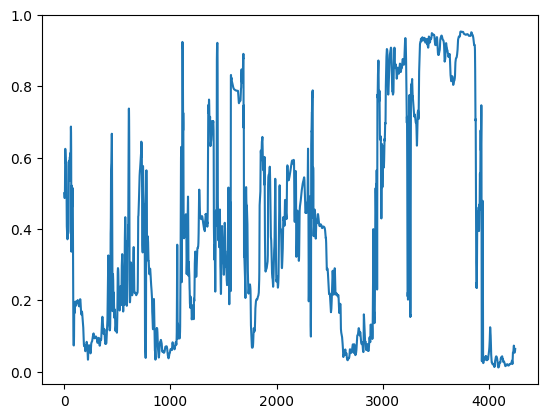

In [93]:
plt.plot(predictions2)

In [21]:
def createRealTimeTestData(dataset,start,end):
    result = pd.read_csv(dataset)
    result = result[start:end]
    result['EulerX'] = 0
    result['EulerY'] = 0
    result['EulerZ'] = 0
    print(len(result))
    result['Roll'],result['Pitch'],result['Yaw'] = result['Pitch'],result['Roll'],result['Yaw']
    result['EulerX'],result['EulerY'],result['EulerZ'] = result['Roll'],result['Pitch'],result['Yaw']        
    result = result.drop(columns=['Timestamp','Roll','Yaw','Pitch'])
    for col in range(9):
        result.iloc[:,col] = uniform_filter1d(result.iloc[:,col],size=10)

    result['Acc_X'],result['Acc_Z'] = result['Acc_Z'],result['Acc_X']
    result['Gyro_X'],result['Gyro_Z'] = result['Gyro_Z'],result['Gyro_X'] 
    result['EulerX'],result['EulerZ'] = result['EulerZ'],result['EulerX'] 
    result['Acc_X'] = result['Acc_X']/-9.8
    result['Acc_Y'] = result['Acc_Y']/-9.8
    result['Acc_Z'] = result['Acc_Z']/-9.8


    test = result
    
    print(test.head())
    return test

def runRealTimePredictions(test):
    predictions = []
    for i in range(250,len(test)-500):
        x = test[i:i+500].reset_index(drop=True)
        test_tensor = tf.convert_to_tensor(x)
        predictions.append(model2.predict(np.asarray([test_tensor])).item())
    return predictions

In [23]:
test = createRealTimeTestData('phoneThrow.csv',0,5000)

5000
      Acc_X     Acc_Y     Acc_Z    Gyro_X    Gyro_Y    Gyro_Z     EulerX  \
0 -0.678658 -0.715662  0.255702 -0.086282 -0.051158  0.070950 -82.979675   
1 -0.677669 -0.715948  0.255928 -0.086084 -0.054426  0.067117 -82.955212   
2 -0.673757 -0.716553  0.255977 -0.085122 -0.062642  0.055740 -82.897187   
3 -0.665424 -0.716821  0.254604 -0.082861 -0.070202  0.040774 -82.887897   
4 -0.657385 -0.716357  0.250447 -0.080449 -0.074478  0.028527 -82.990933   

      EulerY     EulerZ  
0  20.706239 -44.641601  
1  20.756321 -44.687820  
2  20.886531 -44.863867  
3  21.036311 -45.217727  
4  20.937774 -45.556826  


In [25]:
predictions = runRealTimePredictions(test)

ValueError: in user code:

    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\prach\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_8" is incompatible with the layer: expected shape=(None, 1000, 9), found shape=(None, 500, 9)


In [ ]:
plt.plot(predictions)

In [2]:
import tensorflow as tf
saved_model_dir = "model2"
# Convert the model
converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir) # path to the SavedModel directory

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS] 
converter._experimental_lower_tensor_list_ops = False
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert() 
open("model.tflite", "wb").write(tflite_model)


97856

sh tensorflow/lite/tools/build_aar.sh  --input_models=model.tflite  --target_archs=x86,x86_64,arm64-v8a,armeabi-v7a
